In [1]:
from __future__ import unicode_literals

import sys
import os
from bs4 import BeautifulSoup
import urllib2
import cv2
from matplotlib import pyplot as plt
import matplotlib
from PIL import Image, ImageDraw, ImageFont

In [2]:
# from https://stackoverflow.com/questions/4460921/extract-the-first-paragraph-from-a-wikipedia-article-python
import re
import textwrap
import yaml
import urllib
import urllib2
import random

import wikipedia

In [3]:
# set utf-8
stdi, stdo, stde = sys.stdin, sys.stdout, sys.stderr
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdin, sys.stdout, sys.stderr = stdi, stdo, stde
sys.getdefaultencoding()

'utf-8'


In [4]:
OUTPUT_PATH = '/home/ziweihe/sdb1/cvdata/wikipages500_3/'
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

In [5]:
DATA_SIZE = 500
IMG_SIZE = (227, 227)

In [6]:
LANG = {
    'en': 'https://en.wikipedia.org',
    'zh': 'https://zh.wikipedia.org',
    'ru': 'https://ru.wikipedia.org'
}

In [7]:
class WikipediaError(Exception):
    pass

In [8]:
class Wikipedia:
    url_article = 'http://%s.wikipedia.org/w/index.php?action=raw&title=%s'
    url_image = 'http://%s.wikipedia.org/w/index.php?title=Special:FilePath&file=%s'
    url_search = 'http://%s.wikipedia.org/w/api.php?action=query&list=search&srsearch=%s&sroffset=%d&srlimit=%d&format=yaml'
   
    def __init__(self, lang):
        self.lang = lang
   
    def __fetch(self, url):
        request = urllib2.Request(url)
        request.add_header('User-Agent', 'Mozilla/5.0')
       
        try:
            result = urllib2.urlopen(request)
        except urllib2.HTTPError, e:
            raise WikipediaError(e.code)
        except urllib2.URLError, e:
            raise WikipediaError(e.reason)
       
        return result
   
    def article(self, article):
        url = self.url_article % (self.lang, urllib.quote_plus(article))
        content = self.__fetch(url).read()
       
        if content.upper().startswith('#REDIRECT'):
            match = re.match('(?i)#REDIRECT \[\[([^\[\]]+)\]\]', content)
           
            if not match == None:
                return self.article(match.group(1))
           
            raise WikipediaError('Can\'t found redirect article.')
       
        return content
   
    def image(self, image, thumb=None):
        url = self.url_image % (self.lang, image)
        result = self.__fetch(url)
        content = result.read()
       
        if thumb:
            url = result.geturl() + '/' + thumb + 'px-' + image
            url = url.replace('/commons/', '/commons/thumb/')
            url = url.replace('/' + self.lang + '/', '/' + self.lang + '/thumb/')
           
            return self.__fetch(url).read()
       
        return content
   
    def search(self, query, page=1, limit=10):
        offset = (page - 1) * limit
        url = self.url_search % (self.lang, urllib.quote_plus(query), offset, limit)
        content = self.__fetch(url).read()
       
        parsed = yaml.load(content)
        search = parsed['query']['search']
       
        results = []
       
        if search:
            for article in search:
                title = article['title'].strip()
               
                snippet = article['snippet']
                snippet = re.sub(r'(?m)<.*?>', '', snippet)
                snippet = re.sub(r'\s+', ' ', snippet)
                snippet = snippet.replace(' . ', '. ')
                snippet = snippet.replace(' , ', ', ')
                snippet = snippet.strip()
               
                wordcount = article['wordcount']
               
                results.append({
                    'title' : title,
                    'snippet' : snippet,
                    'wordcount' : wordcount
                })
       
        # yaml.dump(results, default_style='', default_flow_style=False,
        #     allow_unicode=True)
        return results

In [9]:
def unwiki(wiki):
    """
   Remove wiki markup from the text.
   """
    wiki = re.sub(r'(?i)\{\{IPA(\-[^\|\{\}]+)*?\|([^\|\{\}]+)(\|[^\{\}]+)*?\}\}', lambda m: m.group(2), wiki)
    wiki = re.sub(r'(?i)\{\{Lang(\-[^\|\{\}]+)*?\|([^\|\{\}]+)(\|[^\{\}]+)*?\}\}', lambda m: m.group(2), wiki)
    wiki = re.sub(r'\{\{[^\{\}]+\}\}', '', wiki)
    wiki = re.sub(r'(?m)\{\{[^\{\}]+\}\}', '', wiki)
    wiki = re.sub(r'(?m)\{\|[^\{\}]*?\|\}', '', wiki)
    wiki = re.sub(r'(?i)\[\[Category:[^\[\]]*?\]\]', '', wiki)
    wiki = re.sub(r'(?i)\[\[Image:[^\[\]]*?\]\]', '', wiki)
    wiki = re.sub(r'(?i)\[\[File:[^\[\]]*?\]\]', '', wiki)
    wiki = re.sub(r'\[\[[^\[\]]*?\|([^\[\]]*?)\]\]', lambda m: m.group(1), wiki)
    wiki = re.sub(r'\[\[([^\[\]]+?)\]\]', lambda m: m.group(1), wiki)
    wiki = re.sub(r'\[\[([^\[\]]+?)\]\]', '', wiki)
    wiki = re.sub(r'(?i)File:[^\[\]]*?', '', wiki)
    wiki = re.sub(r'\[[^\[\]]*? ([^\[\]]*?)\]', lambda m: m.group(1), wiki)
    wiki = re.sub(r"''+", '', wiki)
    wiki = re.sub(r'(?m)^\*$', '', wiki)

    return wiki

def unhtml(html):
    """
   Remove HTML from the text.
   """
    html = re.sub(r'(?i)&nbsp;', ' ', html)
    html = re.sub(r'(?i)<br[ \\]*?>', '\n', html)
    html = re.sub(r'(?m)<!--.*?--\s*>', '', html)
    html = re.sub(r'(?i)<ref[^>]*>[^>]*<\/ ?ref>', '', html)
    html = re.sub(r'(?m)<.*?>', '', html)
    html = re.sub(r'(?i)&amp;', '&', html)

    return html

def punctuate(text):
    """
   Convert every text part into well-formed one-space
   separate paragraph.
   """
    text = re.sub(r'\r\n|\n|\r', '\n', text)
    text = re.sub(r'\n\n+', '\n\n', text)

    parts = text.split('\n\n')
    partsParsed = []

    for part in parts:
        part = part.strip()

        if len(part) == 0:
            continue

        partsParsed.append(part)

    return '\n\n'.join(partsParsed)


In [10]:
def article_urls_crawl(prefix, root_url, count):
    atc_list = set([])
    link_list = set([root_url])
    while True:
        url = random.choice(tuple(link_list))
        try:
            content = urllib.urlopen(url)
        except:
            continue
#         print urllib.urlopen(url).headers.getheader('Content-Type')
        soup = BeautifulSoup(content, "html.parser")
        base=soup.find('div', id="bodyContent")

        for link in BeautifulSoup(str(base), "html.parser").findAll("a"):
            if 'href' in link.attrs:  # Make sure it is link
                if link['href'].startswith('/wiki/') and prefix + link['href'] != url:
                    link_list.add(prefix + link['href'])
                if ( 
                    link['href'].startswith('/wiki/') and  # Make sure it is a wiki page
                    len(link['href'].split('/')) == 3 and  # Make sure it is an article
                    len(link['href'].split(':')) == 1      # Make sure it is not category
                ):
#                     print(link['href'])
                    title = str(link['href'])
                    title = urllib.unquote(title).decode('utf8')
                    print title
                    atc_list.add(prefix + title)
                    if len(atc_list) == count:
                        print('fetched ' + str(count) + ' article urls from ' + prefix + '\n')
                        return atc_list

urls_by_lang = {}

for key in LANG:
    urls_by_lang[key] = article_urls_crawl(LANG[key], LANG[key], DATA_SIZE)

/wiki/Википедия
/wiki/Свободный_контент
/wiki/Русский_язык
/wiki/Проханов,_Иван_Степанович
/wiki/Проханов,_Иван_Степанович
/wiki/Проханов,_Иван_Степанович
/wiki/29_апреля
/wiki/1869_год
/wiki/Русское_зарубежье
/wiki/Молоканство
/wiki/Проханов,_Александр_Степанович
/wiki/Проханов,_Ярослав_Иванович
/wiki/Проханов,_Александр_Андреевич
/wiki/Святой_Дух
/wiki/Русский_евангельский_союз
/wiki/Петербургское_пробуждение
/wiki/Всероссийский_союз_евангельских_христиан
/wiki/Вероучение_Проханова
/wiki/Христомол
/wiki/Песнь_Возрождения_(сборник_гимнов)
/wiki/Новая,_или_Евангельская_жизнь
/wiki/Евангельские_коммуны_в_СССР
/wiki/Иосиф_Сталин
/wiki/Город_Солнца
/wiki/Евангельск
/wiki/Невозвращенцы
/wiki/Евангельские_христиане_(прохановцы)
/wiki/Всемирный_союз_евангельских_христиан
/wiki/Проханов,_Иван_Степанович
/wiki/Слейвен,_Берни
/wiki/Слейвен,_Берни
/wiki/Английский_язык
/wiki/1960_год
/wiki/Пейсли
/wiki/Шотландия
/wiki/Ирландия
/wiki/Шотландия
/wiki/Футбол
/wiki/Нападающий_(футбол)
/wiki/Гринок_М

/wiki/Жак,_Вальтер_Людвигович
/wiki/Марцинковский,_Владимир_Филимонович
/wiki/Корнталь-Мюнхинген
/wiki/Евангелизм
/wiki/Жак,_Вальтер_Людвигович
/wiki/Первая_мировая_война
/wiki/И._С._Проханов
/wiki/Всемирный_союз_евангельских_христиан
/wiki/Марцинковский,_Владимир_Филимонович
/wiki/Евангельская_вера
/wiki/Вторая_мировая_война
/wiki/Третий_рейх
/wiki/Павлов,_Василий_Гурьевич
/wiki/Мазаев,_Дей_Иванович
/wiki/Фетлер,_Вильгельм_Андреевич
/wiki/Каргель,_Иван_Вениаминович
/wiki/Проханов,_Иван_Степанович
/wiki/Иванов,_Василий_Васильевич_(пресвитер)
/wiki/Ливен,_Софья_Павловна
/wiki/Павлов,_Павел_Васильевич_(баптист)
/wiki/Иванов-Клышников,_Павел_Васильевич
/wiki/Тимошенко,_Михаил_Данилович
/wiki/Карев,_Александр_Васильевич
/wiki/Иоанн_Марк
/wiki/Водневский,_Николай_Александрович
/wiki/Бычков,_Алексей_Михайлович
/wiki/Винс,_Георгий_Петрович
/wiki/Кушнир,_Вера_Сергеевна
/wiki/Савинский,_Сергей_Никитович
/wiki/Каретникова,_Марина_Сергеевна
/wiki/Санников,_Сергей_Викторович
/wiki/Гусли_(сборник_г

/wiki/自由內容
/wiki/米歇尔·阿弗拉克
/wiki/叙利亚
/wiki/哲學家
/wiki/社会学
/wiki/阿拉伯民族主义
/wiki/中產階級
/wiki/共产主义
/wiki/社会主义
/wiki/叙利亚－黎巴嫩共产党
/wiki/阿拉伯復興運動
/wiki/阿拉伯復興社會黨
/wiki/埃及總統列表
/wiki/贾迈勒·阿卜杜-纳赛尔
/wiki/阿拉伯聯合共和國
/wiki/黎巴嫩
/wiki/伊拉克
/wiki/阿拉伯世界
/wiki/阿拉伯民族主义
/wiki/资本主义
/wiki/共产主义
/wiki/卡尔·马克思
/wiki/辩证唯物主义
/wiki/阿拉伯社会主义
/wiki/政教分离
/wiki/世俗化
/wiki/无神论
/wiki/基督徒
/wiki/伊斯兰教
/wiki/乐声安峰
/wiki/福克兰群岛
/wiki/卢旺达
/wiki/欧洲超级杯冠军主教练列表
/wiki/欧洲冠军联赛冠军主教练列表
/wiki/阿積士四角賽
/wiki/松露
/wiki/塊菌屬
/wiki/凯瑟琳·安·波特
/wiki/欧·亨利
/wiki/欧·亨利奖
/wiki/試播集_(水行俠)
/wiki/DC漫畫
/wiki/环颈潜鸭
/wiki/中国国际救援队
/wiki/中华人民共和国
/wiki/吉隆坡市政局
/wiki/吉隆坡
/wiki/向忠发
/wiki/湖北省
/wiki/汉阳府
/wiki/汉川市
/wiki/上海市
/wiki/中国共产党中央政治局
/wiki/中国共产党中央委员会总书记
/wiki/中国共产党
/wiki/中共中央主要负责人
/wiki/二七大罷工
/wiki/中国共产党中央政治局
/wiki/中国共产党
/wiki/冰岛
/wiki/间歇泉
/wiki/穆罕默德六世_(摩洛哥)
/wiki/徵兵制
/wiki/摩洛哥议会
/wiki/尼古拉斯·马杜罗
/wiki/委內瑞拉玻利瓦
/wiki/石油币
/wiki/喀拉拉邦
/wiki/2018年北印度洋氣旋季
/wiki/雅加達
/wiki/2018年亞洲運動會
/wiki/2018年亚洲运动会开幕式
/wiki/諾貝爾和平獎
/wiki/聯合國
/wiki/科菲·安南
/wiki/2018年8月逝世人物列表
/wiki/斯特凡·卡爾·斯蒂芬森
/wiki/鮑勃·

In [11]:
def getChinese(context):
    context = context.decode("utf-8") # convert context from str to unicode
    filtrate = re.compile(u'[^\u4E00-\u9FA5]') # non-Chinese unicode range
    context = filtrate.sub(r'', context) # remove all non-Chinese characters
    context = context.encode("utf-8") # convert unicode back to str
    return context

Заглавная_страница


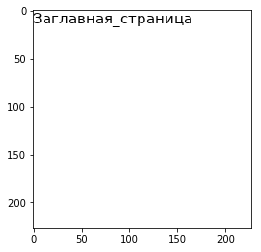

In [12]:
text = "Заглавная_страница"
print text
image = Image.new('L', IMG_SIZE, 255)
draw = ImageDraw.Draw(image)
font = ImageFont.truetype('/usr/share/fonts/dejavu/DejaVuSans.ttf', 15)
margin = 0
offset = 0
for line in textwrap.wrap(text, width=23):
    draw.text((margin, offset), line, font=font, fill="#000000")
    offset += font.getsize(line)[1]
plt.imshow(image)

In [13]:
def generate_imgs(langs, urls_by_lang, count, fontsizerange):
    for key in langs:
        print 'generating imgs for ' + key
        i = 0
        while i < count:
            wikipedia.set_lang(key)
            res = None
            try:
                res = wikipedia.summary(random.choice(tuple(urls_by_lang[key])).split('/')[-1])
            except:
                continue
            
            text = ""
            if key == 'en':
                for n in re.findall(ur'[a-zA-Z ]+',res):
                    text = text + n
            elif key == 'zh':
                for n in re.findall(ur'[\u4e00-\u9fff]+',res):
                    text = text + n
#             print text


            fontsize = random.randint(fontsizerange[0], fontsizerange[1])
            fontwidth = IMG_SIZE[1]/(fontsize/3*4)*3

            image = Image.new('L', IMG_SIZE, 255)
            draw = ImageDraw.Draw(image)
            if key == 'en' or key == 'ru':
                font = ImageFont.truetype('/usr/share/fonts/dejavu/DejaVuSans.ttf', random.randint(fontsizerange[0], fontsizerange[1]))
                margin = 0
                offset = 0
                for line in textwrap.wrap(text, width=fontwidth):
                    draw.text((margin, offset), line, font=font, fill="#000000")
                    offset += font.getsize(line)[1]
            elif key == 'zh':
                font = ImageFont.truetype('/home/ziweihe/fonts/msyh.ttf', random.randint(fontsizerange[0], fontsizerange[1]))
                margin = 0
                offset = 0
                for line in textwrap.wrap(text, width=fontwidth):
                    draw.text((margin, offset), line, font=font, fill="#000000")
                    offset += font.getsize(line)[1]
            image.save(OUTPUT_PATH + key + '-' + str(i) + '-wiki.jpg')
            i += 1

In [14]:
generate_imgs(LANG, urls_by_lang, DATA_SIZE, (60, 60))

generating imgs for ru
generating imgs for en
generating imgs for zh


/home/ziweihe/anaconda2/lib/python2.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 174 of the file /home/ziweihe/anaconda2/lib/python2.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))
